# H16 Notebook — Organized
This notebook studies **H = T + λ H₁₆(√α x)** in the HO(ω_basis) basis using Gauss–Hermite quadrature with *unweighted* basis arrays (the Gaussian factor is carried by the quadrature weights).

**Sections**
1. Imports & configuration
2. Hermite utilities
3. Basis functions (unweighted)
4. Matrix builders (T and ⟨x^k⟩)
5. H₁₆ operator from ⟨x^k⟩
6. Solver `solve_H16`
7. Plot helper `plot_V16`
8. Example A — Plot V(x)
9. Example B — Minimal: V(x) & ψₖ
10. Example C — ψ₀..ψ₂ offset by Eₖ
11. Example D — Weighted HO components (n<50, ≥~80% coverage)

In [13]:
import numpy as np
#from numpy.linalg import eigh
from scipy.linalg import eigh
from math import factorial, pi
import scipy.special as sp  # roots_hermite
import matplotlib.pyplot as plt
from numpy.polynomial.hermite import hermgauss, hermval, herm2poly

## 2) Hermite utilities
Physicists’ Hermite polynomials via `hermval`, and HO normalization constant `C_n(α)`.

In [14]:
def He(n, xi):
    """Physicists' Hermite polynomial H_n(ξ)."""
    coeffs = np.zeros(n + 1)
    coeffs[-1] = 1.0
    return hermval(xi, coeffs)


def Cn(n, alpha):
    """
    HO normalization for φ_n(x) = Cn * H_n(ξ) * e^{-ξ^2/2}, with ξ = √α x.
    """
    log_Cn = 0.25*np.log(alpha/np.pi) - 0.5*(n*np.log(2.0) + sp.gammaln(n+1))
    return np.exp(log_Cn)
    #return (alpha / pi) ** 0.25 / np.sqrt((2.0 ** n) * factorial(n))

## 3) Basis functions (unweighted)
Unweighted basis omits the Gaussian factor; Gauss–Hermite weights carry $e^{-\xi^2}$. We also include $\tfrac{d\phi_n}{dx}$ in unweighted form.

In [15]:
def phi_unweighted(n, xi, alpha):
    """
    e^{-ξ^2/2} omitted (handled by GH weights); Φ_unw = Cn * H_n(ξ)
    """
    return Cn(n, alpha) * He(n, xi)


def dphi_unweighted(n, xi, alpha):
    """
    derivative w.r.t x, but without the Gaussian factor (pairs with GH weights)
    φ'_n(x) unweighted: Cn * √α * [2n H_{n-1}(ξ) − ξ H_n(ξ)]
    """
    if n == 0:
        return Cn(0, alpha) * np.sqrt(alpha) * (-xi * He(0, xi))
    return Cn(n, alpha) * np.sqrt(alpha) * (2.0 * n * He(n - 1, xi) - xi * He(n, xi))

## 4) Matrix builders
Construct T via gradient form and ⟨x^k⟩ for even k = 2..16 on the GH grid.

In [16]:
def build_mats16(N, nq, m=1.0, omega_basis=1.0, hbar=1.0):
    """
    Returns:
      T     = ⟨m| -(ħ²/2m) d²/dx² |n⟩ via gradient form
      Xpow  = dict of even powers {2,4,...,16} with Xpow[k] = ⟨m| x^k |n⟩
      alpha = m*omega_basis/hbar
    """
    alpha = m * omega_basis / hbar
    #xi, w = hermgauss(nq)
    xi, w = sp.roots_hermite(nq)  # ∫ g(ξ) e^{-ξ²} dξ ≈ Σ w_i g(ξ_i)
    dx_factor = 1.0 / np.sqrt(alpha)  # dx = dξ / √α
    # Unweighted basis arrays evaluated on GH nodes
    Phi = np.array([phi_unweighted(n, xi, alpha) for n in range(N)])
    dPhi = np.array([dphi_unweighted(n, xi, alpha) for n in range(N)])

    # Kinetic via gradient form: T_mn = (ħ²/2m) ∫ (∂x φ_m)(∂x φ_n) dx
    prefT = (hbar * hbar) / (2.0 * m)
    T = prefT * (dPhi @ np.diag(w) @ dPhi.T) * dx_factor

    # Even powers: x^k = ξ^k / α^{k/2}
    Xpow = {}
    for k in (2, 4, 6, 8, 10, 12, 14, 16):
        Xpow[k] = (Phi @ np.diag(w * (xi ** k) / (alpha ** (k / 2.0))) @ Phi.T) * dx_factor

    # Symmetrize (remove tiny float asymmetries)
    T = 0.5 * (T + T.T)
    for k in Xpow:
        Xpow[k] = 0.5 * (Xpow[k] + Xpow[k].T)
    return T, Xpow, alpha

## 5) H₁₆ operator from ⟨x^k⟩
Use `herm2poly` to convert $H_{16}(\xi)$ into the power basis, substitute $\xi = \sqrt{\alpha}x$, and assemble the operator.

In [17]:
def H16_operator_from_Xpow(Xpow, alpha, N, lam=1.0):
    """
    Build H16(√α x) as a matrix in the HO basis.

    Let H16(ξ) = Σ_j a_j ξ^j  (even j=0..16), with 'a' from herm2poly on the Hermite basis.
    Substitute ξ = √α x ⇒ ξ^j = α^{j/2} x^j.

    To mirror your H4 code style (which multiplies by Cn(4, α)),
    we include the analogous Cn(16, α) factor up front.
    """
    # Hermite-basis coeffs for H16: only index 16 is 1
    e16 = np.zeros(17)
    e16[16] = 1.0
    a = herm2poly(e16)  # power-basis coefficients a[j] for H16(ξ) = Σ a[j] ξ^j

    V = np.zeros((N, N))
    for j in range(2, 17, 2):
        if j == 0:
            #There is a constant term a[0]; #it acts like a[0] * I
            if abs(a[0]) > 0:
                V += a[0] * np.eye(N)
        else:
            V += a[j] * (alpha ** (j / 2.0)) * Xpow[j]

    return Cn(16, alpha) * lam * V

## 6) Solver `solve_H16`
Assemble **H = T + λ H₁₆(√α x)** and diagonalize (`eigh`, columns are eigenvectors).

In [18]:
def solve_H16(N=60, nq=None, m=1.0, omega_phys=1.0, omega_basis=None, hbar=1.0, lam=1.0):
    """
    Constructs H = T + λ H16(√α x) in the HO(omega_basis) basis and diagonalizes it.
    By default, omega_basis = omega_phys (good, stable choice).
    Returns: E, Vvecs, H, T, V_H16, Xpow, alpha
    """
    if omega_basis is None:
        omega_basis = omega_phys
    if nq is None:
        nq = 220  # higher for stability with x^16

    T, Xpow, alpha = build_mats16(N, nq, m=m, omega_basis=omega_basis, hbar=hbar)
    V_H16 = H16_operator_from_Xpow(Xpow, alpha, N, lam=lam)
    H = T + V_H16
    E, Vvecs = eigh(H, driver="evd", check_finite=False)
    return E, Vvecs, H, T, V_H16, Xpow, alpha

## 7) Plot helper `plot_V16`
Quick visualization of $V(x) = \lambda H_{16}(\sqrt{\alpha}x)$.

In [19]:
def plot_V16(alpha, lam=1.0, x_range=(-5, 5), n_points=400):
    """
    Plot the potential term V(x) = λ H16(√α x).
    Mirrors your H4 plotting style.
    """
    x = np.linspace(x_range[0], x_range[1], n_points)
    xi = (np.sqrt(alpha) * x)
    e16 = np.zeros(17)
    e16[16] = 1.0
    H16_vals = hermval(xi, e16)  # H16(ξ)
    V = Cn(16, alpha) * lam * H16_vals

    plt.figure(figsize=(6, 4))
    plt.plot(x, V, label=r"$V(x) = \lambda H_{16}(\sqrt{\alpha}x)$")
    plt.axhline(0, linewidth=0.5)
    plt.xlabel("x"); plt.ylabel("V(x)")
    plt.title("Potential from 16th Hermite polynomial")
    plt.legend(); plt.grid(True)

## 8) Example A — Plot V(x)
Build basis once and plot V(x).

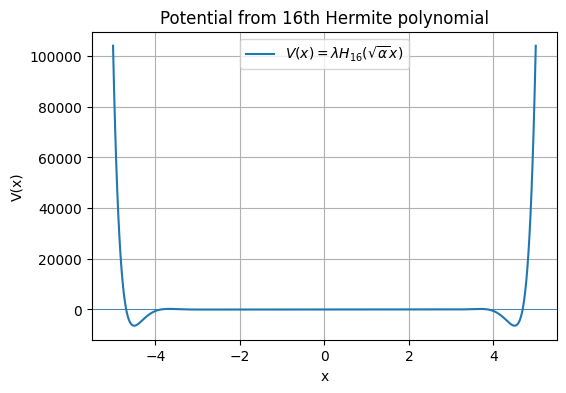

In [20]:
T, Xpow, alpha = build_mats16(N=60, nq=80, m=1.0, omega_basis=1.0, hbar=1.0)
plot_V16(alpha, lam=1)
#plt.ylim(-10,10)

## 9) Example B — Minimal: V(x) & one eigenstate
Solve for a given (N, λ), reconstruct $\psi_k(x)$, and plot alongside $V(x)$.

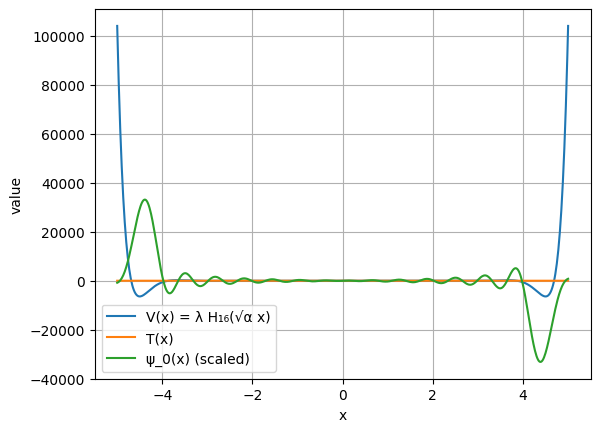

In [21]:
k = 0
lam = 1
N = 60
nq = 220

# Solve H = T + λ H16(√α x)
E, Vvecs, H, Tmat, V_H16, Xpow, alpha = solve_H16(
    N=N, nq=220, m=1.0, omega_phys=1.0, omega_basis=1.0, hbar=1.0, lam=lam
)

# Real-space grid
x = np.linspace(-5, 5, 600)
xi = np.sqrt(alpha) * x

# Potential V(x) = λ H16(√α x); include the Cn(16,α) factor here
e16 = np.zeros(17); e16[16] = 1.0
Vx = Cn(16, alpha) * lam * hermval(xi, e16)

# "T(x)" curve like in your H4 block (uses n=0 derivative squared)

T_curve = dphi_unweighted(0, xi, alpha) * dphi_unweighted(0, xi, alpha)

# Build HO basis on the grid and reconstruct ψ_k(x)
phis = np.array([Cn(n, alpha) * He(n, xi) * np.exp(-xi ** 2 / 2) for n in range(Vvecs.shape[0])])
psi_k = Vvecs[:, k] @ phis

# Also plot H16 basis polynomial (no Gaussian), analogous to your phi_4 line
phi_16 = Cn(16, alpha) * He(16, xi)  # (no exp factor)

# Scale ψ_k for visibility on the same axis
range_V = Vx.max() - Vx.min()
if range_V == 0:
    range_V = 1.0
psi_scale = 0.3 * range_V / (np.max(np.abs(psi_k)) + 1e-12)

plt.figure()
plt.plot(x, Vx, label='V(x) = λ H₁₆(√α x)')
plt.plot(x, T_curve, label='T(x)')
plt.plot(x, psi_scale * psi_k, label=f'ψ_{k}(x) (scaled)')
#plt.plot(x, phi_16, label='C₁₆ H₁₆(√α x)')
plt.xlabel('x'); plt.ylabel('value'); plt.legend(); plt.grid(True); plt.show()

#print(E[:5]); print(Vvecs[:20, k])

11## 10) Example C — ψ₀..ψ₂ offset by energies
Plot V(x) and overlay ψ₀..ψ₂ shifted by their eigen-energies $E_k$.

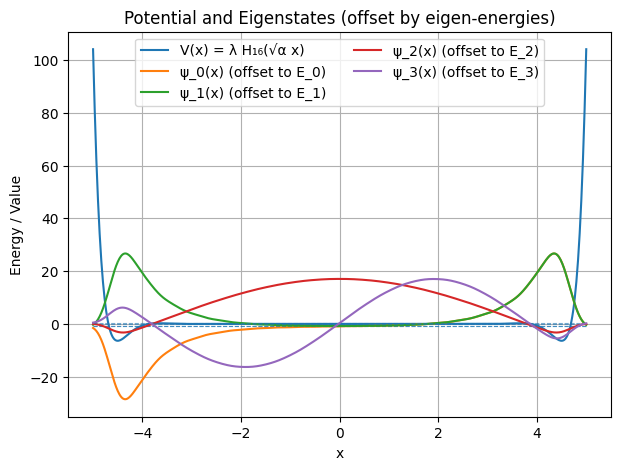

In [22]:
lam = 0.001
N = 100
nq = max(3*N, 240)

E, Vvecs, H, Tmat, V_H16, Xpow, alpha = solve_H16(
    N=N, nq=nq, m=1.0, omega_phys=1.0, omega_basis=1.0, hbar=1.0, lam=lam
)

x = np.linspace(-5, 5, 600)
xi = np.sqrt(alpha) * x
e16 = np.zeros(17); e16[16] = 1.0
Vx = Cn(16, alpha) * lam * hermval(xi, e16)

phis = np.array([Cn(n, alpha) * He(n, xi) * np.exp(-xi ** 2 / 2) for n in range(Vvecs.shape[0])])
psis = np.array([Vvecs[:, k] @ phis for k in range(5)])

range_V = Vx.max() - Vx.min()
max_psi = np.max(np.abs(psis))
scale = (0.25 * range_V) / (max_psi + 1e-12)

plt.figure(figsize=(7, 5))
plt.plot(x, Vx, label='V(x) = λ H₁₆(√α x)')
for k in range(4):
    plt.hlines(E[k], x[0], x[-1], linestyles='--', linewidth=0.8, alpha=0.6)
    plt.plot(x, E[k] + scale * psis[k], label=f'ψ_{k}(x) (offset to E_{k})')
plt.xlabel('x'); plt.ylabel('Energy / Value'); plt.legend(ncol=2); plt.grid(True)
plt.title('Potential and Eigenstates (offset by eigen-energies)'); plt.show()

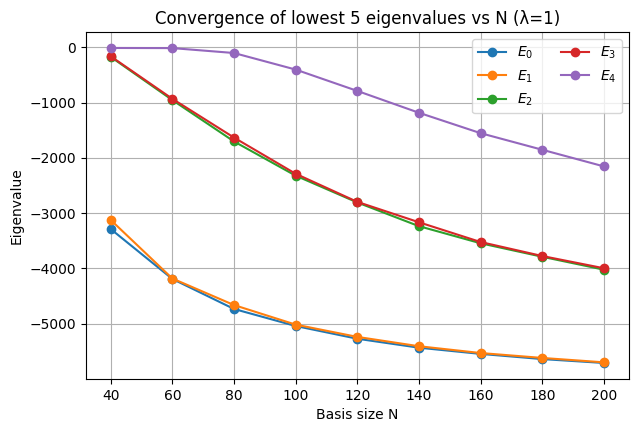

In [23]:
def convergence_diagnostic(
        N_list=(40, 60, 80, 100, 120, 160),
        lam=1.0,
        n_eval=5,
        m=1.0,
        omega_phys=1.0,
        omega_basis=1.0,
        hbar=1.0,
):
    """
    Sweep N and plot the first `n_eval` eigenvalues to check convergence.
    Uses solve_H16(...) defined above. Gauss–Hermite resolution is chosen
    inside solve_H16 as nq = max(3*N, 240).
    """
    N_list = list(N_list)
    all_E = []

    for N in N_list:
        E, Vvecs, H, T, V_H16, Xpow, alpha = solve_H16(
            N=N, nq=220, m=m, omega_phys=omega_phys,
            omega_basis=omega_basis, hbar=hbar, lam=lam
        )
        all_E.append(E[:n_eval])

    all_E = np.array(all_E)  # shape = (len(N_list), n_eval)

    # Plot each eigenvalue k vs N
    plt.figure(figsize=(7, 4.5))
    for k in range(min(n_eval, all_E.shape[1])):
        plt.plot(N_list, all_E[:, k], marker='o', label=f"$E_{k}$")
    plt.xlabel("Basis size N")
    plt.ylabel("Eigenvalue")
    plt.title(f"Convergence of lowest {min(n_eval, all_E.shape[1])} eigenvalues vs N (λ={lam})")
    plt.grid(True)
    plt.legend(ncol=2)
    plt.show()



# Example run
_ = convergence_diagnostic(
    N_list=(40, 60, 80, 100, 120,140, 160, 180, 200),
    lam=1,
    n_eval=5,
    m=1,
    omega_phys=1.0,
    omega_basis=1.0,
    hbar=1.0,
)

In [24]:

# Choose λ and N (edit these)
lam_use = 0.00001
N_use   = 80

# Solve fresh with the chosen settings
E, Vvecs, *_ = solve_H16(N=N_use, nq=None, m=1.0,
                         omega_phys=1.0, omega_basis=1.0,
                         hbar=1.0, lam=lam_use)

np.set_printoptions(precision=6, suppress=True)

print(f"λ={lam_use}, N={N_use}")

# 1) First 5 eigenvalues
print("First 5 eigenvalues (E0..E4):")
print(np.array2string(E[:5], precision=6, separator=", "))

# 2) Contributions matrix (|c_nk|^2) for n=0..23 and k=0..3
rows = 24  # HO basis rows n = 0..23
k_show = 4  # states k = 0..3
C = Vvecs[:rows, :k_show]  # slice (24 × 4)
P = (C * C.conj()).real  # probabilities |c_nk|^2

print("\nHO basis contributions (|c_nk|^2): rows n=0..23, columns k=0..3")
header = " n |    ψ0         ψ1         ψ2         ψ3"
print(header)
print("-" * len(header))
for n in range(rows):
    print(f"{n:2d} | " + "  ".join(f"{P[n, k]:10.6f}" for k in range(k_show)))

col_sums_24 = P.sum(axis=0)
print("\nColumn sums over n=0..23 (≤ 1.0 since only first 24 rows are shown):")
print("      " + "  ".join(f"Σₙ|c_n{k}|²={col_sums_24[k]:.6f}" for k in range(k_show)))

# 3) Top-10 contributing HO indices per state (by |c_nk|^2 over FULL basis)
print("\nTop-10 HO basis contributors per state (by |c_nk|^2 over full basis):")
for k in range(k_show):
    weights = (Vvecs[:, k] * Vvecs[:, k].conj()).real
    top_idx = np.argsort(weights)[::-1][:10]
    print(f"\nState k={k}:")
    print(" rank   n    |c_nk|^2")
    print(" ---------------------")
    for r, n in enumerate(top_idx, 1):
        print(f"  {r:2d}   {n:3d}   {weights[n]:.6f}")

λ=1e-05, N=80
First 5 eigenvalues (E0..E4):
[0.042635, 0.17066 , 0.384361, 0.684057, 1.069874]

HO basis contributions (|c_nk|^2): rows n=0..23, columns k=0..3
 n |    ψ0         ψ1         ψ2         ψ3
-------------------------------------------
 0 |   0.605289    0.000000    0.306259    0.000000
 1 |   0.000000    0.320161    0.000000    0.460687
 2 |   0.208214    0.000000    0.044233    0.000000
 3 |   0.000000    0.286548    0.000000    0.005342
 4 |   0.101464    0.000000    0.190225    0.000000
 5 |   0.000000    0.199140    0.000000    0.091254
 6 |   0.050579    0.000000    0.212739    0.000000
 7 |   0.000000    0.116339    0.000000    0.189883
 8 |   0.023257    0.000000    0.150195    0.000000
 9 |   0.000000    0.055309    0.000000    0.160169
10 |   0.008783    0.000000    0.072748    0.000000
11 |   0.000000    0.018868    0.000000    0.074863
12 |   0.002155    0.000000    0.020868    0.000000
13 |   0.000000    0.003189    0.000000    0.015747
14 |   0.000150    0.000